In [8]:
!pip3 install -r requirements.txt


[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
from PIL import Image
import torchaudio
import torchaudio.transforms as T
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import subprocess
import tempfile
import numpy as np
import shutil
import glob

<h1> Testing </h1>

In [24]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def visualize_mismatches(model, dataloader):
    model.eval()
    feats, labels_all, preds_all, names_all = [], [], [], []

    with torch.no_grad():
        for audio, img, labels, video_ids in dataloader:
            audio, img = audio.to(DEVICE), img.to(DEVICE)
            a, i, fused, out = model(audio, img, return_features=True)
            preds = out.argmax(1).cpu()
            feats.append(fused.cpu())
            labels_all.extend(labels.cpu().tolist())
            preds_all.extend(preds.tolist())
            names_all.extend(video_ids)

    feats = torch.cat(feats).numpy()
    labels_all = np.array(labels_all)
    preds_all = np.array(preds_all)

    # t-SNE projection
    tsne = TSNE(n_components=2, random_state=42, perplexity=10)
    feats_2d = tsne.fit_transform(feats)

    plt.figure(figsize=(10, 7))
    for i, (x, y) in enumerate(feats_2d):
        if preds_all[i] == labels_all[i]:
            plt.scatter(x, y, c="green", alpha=0.6, s=30)
        else:
            plt.scatter(x, y, c="red", alpha=0.9, s=50, marker="x")
            plt.text(x+0.5, y+0.5, names_all[i],
                     fontsize=8, color="black")

    plt.title("Feature Space with Mismatches Highlighted")
    plt.show()


empty_12_seg8.wav -> True: Empty Pred: Full
empty_12_seg9.wav -> True: Empty Pred: Full
empty_11_seg20.wav -> True: Empty Pred: Full
empty_12_seg14.wav -> True: Empty Pred: Full
empty_12_seg28.wav -> True: Empty Pred: Full
empty_11_seg1.wav -> True: Empty Pred: Full
empty_11_seg0.wav -> True: Empty Pred: Full
empty_12_seg29.wav -> True: Empty Pred: Full
empty_12_seg15.wav -> True: Empty Pred: Full
empty_11_seg21.wav -> True: Empty Pred: Full
empty_11_seg23.wav -> True: Empty Pred: Full
empty_12_seg17.wav -> True: Empty Pred: Full
empty_11_seg2.wav -> True: Empty Pred: Full
empty_11_seg3.wav -> True: Empty Pred: Full
empty_12_seg16.wav -> True: Empty Pred: Full
empty_11_seg22.wav -> True: Empty Pred: Full
empty_11_seg32.wav -> True: Empty Pred: Full
empty_11_seg26.wav -> True: Empty Pred: Full
empty_12_seg12.wav -> True: Empty Pred: Full
empty_11_seg7.wav -> True: Empty Pred: Full
empty_11_seg6.wav -> True: Empty Pred: Full
empty_12_seg13.wav -> True: Empty Pred: Full
empty_11_seg27.wav

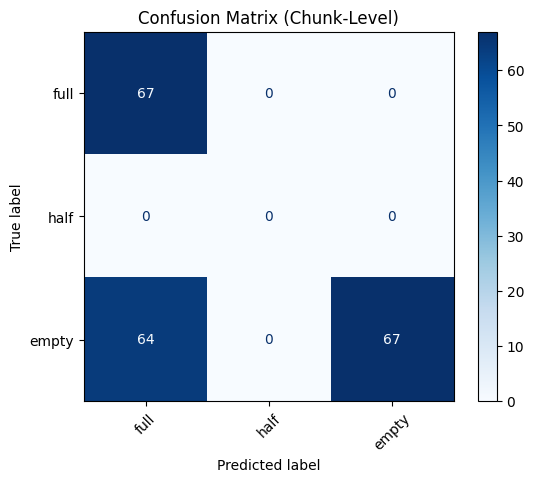

In [26]:
import os, glob, subprocess
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
import torchaudio
import torchaudio.transforms as T
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# ------------------------------
# SETTINGS
# ------------------------------
AUDIO_DIR = "recorded_audio/battery/test"
SEG_DIR = "audio_segments/battery/test"
IMAGE_DIR = "recorded_images/battery/test"
TEST_DIR = "test_videos/battery"
SAMPLE_RATE = 44100
N_MELS = 64
CHUNK_SECONDS = 2
BATCH_SIZE = 8
EPOCHS = 15
MAX_AUDIO_SECONDS = 2
MODEL_PATH = "multimodal_model_battery.pth"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

label_map = {"full": 0, "half": 1, "empty": 2}
LABELS = {v: k.capitalize() for k, v in label_map.items()}

os.makedirs(SEG_DIR, exist_ok=True)


label_map = {"full": 0, "half": 1, "empty": 2}
LABELS = {v: k.capitalize() for k, v in label_map.items()}

# ------------------------------
# PREPROCESSING
# ------------------------------
def extract_audio(video_path, audio_out, sample_rate=SAMPLE_RATE, max_duration=90):
    cmd = ["ffmpeg", "-y", "-i", video_path, "-t", str(max_duration),
           "-ar", str(sample_rate), "-ac", "1", audio_out]
    subprocess.run(cmd, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL, check=True)

def extract_frame(video_path, image_out, timestamp=2.0):
    cmd = ["ffmpeg", "-y", "-i", video_path, "-ss", str(timestamp), "-vframes", "1", image_out]
    subprocess.run(cmd, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL, check=True)

def split_audio_and_frames(video_path, audio_out_dir, image_out_dir,
                           chunk_sec=CHUNK_SECONDS, sample_rate=SAMPLE_RATE):
    base = os.path.splitext(os.path.basename(video_path))[0]
    audio_tmp = os.path.join(audio_out_dir, base + ".wav")
    extract_audio(video_path, audio_tmp, sample_rate=sample_rate)

    waveform, sr = torchaudio.load(audio_tmp)
    if sr != sample_rate:
        waveform = torchaudio.functional.resample(waveform, sr, sample_rate)
    total_samples = waveform.shape[1]
    chunk_samples = chunk_sec * sample_rate

    for i, start in enumerate(range(0, total_samples, chunk_samples)):
        end = min(start + chunk_samples, total_samples)
        seg_waveform = waveform[:, start:end]
        seg_name = f"{base}_seg{i}.wav"
        seg_path = os.path.join(audio_out_dir, seg_name)
        torchaudio.save(seg_path, seg_waveform, sample_rate)

        timestamp = i * chunk_sec
        frame_path = os.path.join(image_out_dir, f"{base}_frame{i}.jpg")
        extract_frame(video_path, frame_path, timestamp=timestamp)

    print(f"[INFO] Processed {video_path} → {i+1} chunks")

def prepare_dataset(raw_videos, audio_dir, image_dir):
    os.makedirs(audio_dir, exist_ok=True)
    os.makedirs(image_dir, exist_ok=True)
    video_files = glob.glob(os.path.join(raw_videos, "*.MOV")) + glob.glob(os.path.join(raw_videos, "*.mp4"))
    for vf in video_files:
        split_audio_and_frames(vf, audio_dir, image_dir)
    print(f"[INFO] Finished preprocessing {len(video_files)} videos.")

# ------------------------------
# IMAGE TRANSFORM
# ------------------------------
gray = transforms.Grayscale(num_output_channels=3)
transform_image = transforms.Compose([
    transforms.Resize((224,224)),
    gray,
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

# ------------------------------
# DATASET
# ------------------------------
class AudioImageDataset(Dataset):
    def __init__(self, audio_dir, image_dir, label_map, transform_image=None):
        self.audio_dir = audio_dir
        self.image_dir = image_dir
        self.label_map = label_map
        self.audio_files, self.labels, self.video_ids = [], [], []

        for file in os.listdir(audio_dir):
            if file.endswith(".wav") and "_seg" in file:
                base_name = file.split("_seg")[0]
                label_str = base_name.split("_")[0].lower()
                if label_str in label_map:
                    self.audio_files.append(file)
                    self.labels.append(label_map[label_str])
                    self.video_ids.append(base_name)

        self.transform_image = transform_image
        self.sample_rate = SAMPLE_RATE
        self.mel = T.MelSpectrogram(sample_rate=self.sample_rate, n_fft=1024,
                                    hop_length=512, n_mels=N_MELS)
        self.db = T.AmplitudeToDB()

    def __len__(self):
        return len(self.audio_files)

    def __getitem__(self, idx):
        audio_file = self.audio_files[idx]   
        audio_path = os.path.join(self.audio_dir, audio_file)
        waveform, sr = torchaudio.load(audio_path)
        if sr != self.sample_rate:
            waveform = torchaudio.functional.resample(waveform, sr, self.sample_rate)
        spec = self.mel(waveform)
        spec = self.db(spec)
        spec = (spec - spec.mean()) / (spec.std() + 1e-6)
        spec = F.interpolate(spec.unsqueeze(0), size=(224,224),
                             mode="bilinear", align_corners=False)
        spec = spec.mean(dim=1)  # [1,224,224]

        # match frame
        frame_file = audio_file.replace("seg", "frame").replace(".wav", ".jpg")
        img_path = os.path.join(self.image_dir, frame_file)
        img = Image.open(img_path).convert("RGB")
        if self.transform_image:
            img = self.transform_image(img)

        label = self.labels[idx]
        # return audio_file instead of base_name
        return spec, img, label, audio_file

# ------------------------------
# MODEL
# ------------------------------
class MultiModalResNet(nn.Module):
    def __init__(self, num_classes=3):
        super().__init__()
        self.audio_model = models.resnet18(pretrained=True)
        self.audio_model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.audio_model.fc = nn.Identity()
        self.image_model = models.resnet18(pretrained=True)
        self.image_model.fc = nn.Identity()
        self.fc = nn.Linear(512*2, num_classes)

    def forward(self, audio, image):
        a = self.audio_model(audio)
        i = self.image_model(image)
        fused = torch.cat([a, i], dim=1)
        out = self.fc(fused)
        return out

# ------------------------------
# TEST FUNCTION
# ------------------------------
mismatched_segments = []   # store only names
def test_model(model_path, audio_dir, image_dir):

    # 1. Load dataset
    test_dataset = AudioImageDataset(audio_dir=audio_dir,
                                     image_dir=image_dir,
                                     label_map=label_map,
                                     transform_image=transform_image)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

    # 2. Load model
    model = MultiModalResNet(num_classes=len(label_map)).to(DEVICE)
    model.load_state_dict(torch.load(model_path, map_location=DEVICE))
    model.eval()
    all_preds, all_labels, all_videos = [], [], []

    # 3. Predict per segment
    with torch.no_grad():
        for audio, img, labels, video_ids in test_loader:
            audio, img = audio.to(DEVICE), img.to(DEVICE)
            outputs = model(audio, img)
            preds = outputs.argmax(1).cpu().tolist()

            # Store for later aggregation
            all_preds.extend(preds)
            all_labels.extend(labels.tolist())
            all_videos.extend(video_ids)

            # 🟢 Print per-segment result
            for seg_pred, seg_true, seg_file in zip(preds, labels, video_ids):
                if seg_pred != seg_true.item():
                    mismatched_segments.append(seg_file)
                    print(f"{seg_file} -> True: {LABELS[seg_true.item()]} "
                        f"Pred: {LABELS[seg_pred]}")

    # 4. Aggregate per video (majority vote)
    video_level = {}
    for vid, lab, pred in zip(all_videos, all_labels, all_preds):
        if vid not in video_level:
            video_level[vid] = {"labels": [], "preds": []}
        video_level[vid]["labels"].append(lab)
        video_level[vid]["preds"].append(pred)

    print("\n=== Video-Level Results ===")
    video_correct, video_total = 0, 0
    y_true, y_pred = [], []

    for vid, d in video_level.items():
        final_pred = max(set(d["preds"]), key=d["preds"].count)
        true_label = d["labels"][0]
        print(f"{vid} (Aggregated) -> True: {LABELS[true_label]}, "
              f"Pred: {LABELS[final_pred]}")

        y_true.append(true_label)
        y_pred.append(final_pred)
        if final_pred == true_label:
            video_correct += 1
        video_total += 1

    acc = video_correct / video_total if video_total > 0 else 0
    print(f"\n=== Test Video-Level Accuracy: {acc*100:.2f}% ===")

    # 6. Confusion matrix
    cm = confusion_matrix(all_labels, all_preds, labels=list(label_map.values()))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                display_labels=list(label_map.keys()))
    disp.plot(cmap="Blues", xticks_rotation=45)
    plt.title("Confusion Matrix (Chunk-Level)")
    plt.show()

    return acc, cm

# ------------------------------
# MAIN
# ------------------------------
if __name__ == "__main__":
    # prepare_dataset(TEST_DIR, AUDIO_DIR, IMAGE_DIR)
    AUDIO_DIR = "audio_segments/battery/test"

    test_acc, cm = test_model(
        model_path=MODEL_PATH,
        audio_dir=AUDIO_DIR,
        image_dir=IMAGE_DIR
    )


In [23]:
print(mismatched_segments)

['empty_12_seg8.wav', 'empty_12_seg9.wav', 'empty_11_seg20.wav', 'empty_12_seg14.wav', 'empty_12_seg28.wav', 'empty_11_seg1.wav', 'empty_11_seg0.wav', 'empty_12_seg29.wav', 'empty_12_seg15.wav', 'empty_11_seg21.wav', 'empty_11_seg23.wav', 'empty_12_seg17.wav', 'empty_11_seg2.wav', 'empty_11_seg3.wav', 'empty_12_seg16.wav', 'empty_11_seg22.wav', 'empty_11_seg32.wav', 'empty_11_seg26.wav', 'empty_12_seg12.wav', 'empty_11_seg7.wav', 'empty_11_seg6.wav', 'empty_12_seg13.wav', 'empty_11_seg27.wav', 'empty_11_seg19.wav', 'empty_11_seg25.wav', 'empty_11_seg31.wav', 'empty_12_seg11.wav', 'empty_11_seg4.wav', 'empty_11_seg5.wav', 'empty_12_seg10.wav', 'empty_11_seg30.wav', 'empty_11_seg24.wav', 'empty_11_seg18.wav', 'empty_11_seg15.wav', 'empty_11_seg29.wav', 'empty_12_seg21.wav', 'empty_11_seg8.wav', 'empty_11_seg9.wav', 'empty_12_seg20.wav', 'empty_11_seg28.wav', 'empty_11_seg14.wav', 'empty_11_seg16.wav', 'empty_12_seg22.wav', 'empty_12_seg23.wav', 'empty_11_seg17.wav', 'empty_11_seg13.wav',